In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-sh/toxic/toxic_34_6.wav
/kaggle/input/data-sh/toxic/toxic_158_3.wav
/kaggle/input/data-sh/toxic/toxic_61_0.wav
/kaggle/input/data-sh/toxic/toxic_238_0.wav
/kaggle/input/data-sh/toxic/toxic_175_1.wav
/kaggle/input/data-sh/toxic/toxic_221_0.wav
/kaggle/input/data-sh/toxic/toxic_62_5.wav
/kaggle/input/data-sh/toxic/toxic_194_0.wav
/kaggle/input/data-sh/toxic/toxic_196_0.wav
/kaggle/input/data-sh/toxic/toxic_53_10.wav
/kaggle/input/data-sh/toxic/toxic_70_0.wav
/kaggle/input/data-sh/toxic/toxic_299_4.wav
/kaggle/input/data-sh/toxic/toxic_50_2.wav
/kaggle/input/data-sh/toxic/toxic_179_0.wav
/kaggle/input/data-sh/toxic/toxic_49_8.wav
/kaggle/input/data-sh/toxic/toxic_35_4.wav
/kaggle/input/data-sh/toxic/toxic_276_0.wav
/kaggle/input/data-sh/toxic/toxic_96_4.wav
/kaggle/input/data-sh/toxic/toxic_14_1.wav
/kaggle/input/data-sh/toxic/toxic_77_0.wav
/kaggle/input/data-sh/toxic/toxic_235_3.wav
/kaggle/input/data-sh/toxic/toxic_49_3.wav
/kaggle/input/data-sh/toxic/toxic_281_0.wav

In [4]:
import tensorflow as tf
import os
import tensorflow_io as tfio
from matplotlib import pyplot as plt

2024-02-10 22:46:16.172956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 22:46:16.173174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 22:46:16.365216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import librosa
def load_wav(file_path):
    file_con = tf.io.read_file(file_path)
    wav,sample_rate = tf.audio.decode_wav(file_con, desired_channels = 1)
    wav = tf.squeeze(wav,axis=-1)
    sample_rate = tf.cast(sample_rate,dtype = tf.int64)
    print(sample_rate)
    wav = tfio.audio.resample(wav,rate_in = sample_rate,rate_out = 22050)
    return wav

In [9]:
toxic = '/kaggle/input/data-sh/toxic/toxic_13_3.wav'
non_toxic = '/kaggle/input/data-sh/non_toxic/non_toxic_341_354.wav'



tf.Tensor(44100, shape=(), dtype=int64)
tf.Tensor(44100, shape=(), dtype=int64)


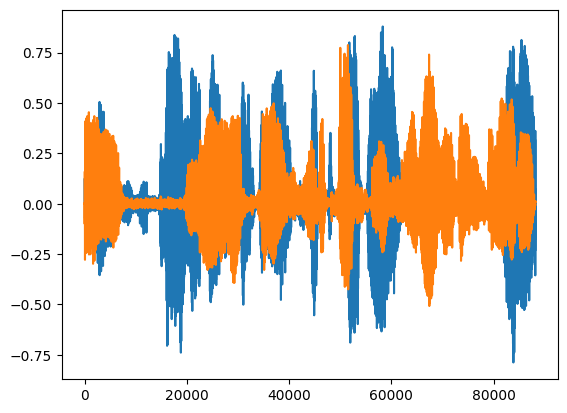

In [10]:
plt.plot(load_wav(toxic))
plt.plot(load_wav(non_toxic))

In [13]:
t_loc = os.path.join('/kaggle','input','data-sh','toxic')
nt_loc = os.path.join('/kaggle','input','data-sh','non_toxic')



In [14]:
#create tf datasets
t_files = tf.data.Dataset.list_files(os.path.join(t_loc,'*.wav'))
nt_files = tf.data.Dataset.list_files(os.path.join(nt_loc ,'*.wav'))


In [15]:
t_files.as_numpy_iterator().next()

b'/kaggle/input/data-sh/toxic/toxic_42_0.wav'

In [16]:
##Adding labels and combining the samples
toxics = tf.data.Dataset.zip((t_files,tf.data.Dataset.from_tensor_slices(tf.ones(len(t_files)))))
non_toxics = tf.data.Dataset.zip((nt_files,tf.data.Dataset.from_tensor_slices(tf.zeros(len(nt_files)))))
data = toxics.concatenate(non_toxics)

In [17]:
len(data)

2292

In [18]:
def preprocess(file_path,label):
    wav = load_wav(file_path)
    spectogram = tf.signal.stft(wav,frame_length = 320,frame_step = 32)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram,axis = 2)
    return spectogram,label

In [19]:
filepath,label = data.shuffle(buffer_size = 10000).as_numpy_iterator().next()





In [20]:
filepath

b'/kaggle/input/data-sh/non_toxic/non_toxic_341_614.wav'

In [21]:
spec, lbl = preprocess(filepath,label)

tf.Tensor(44100, shape=(), dtype=int64)


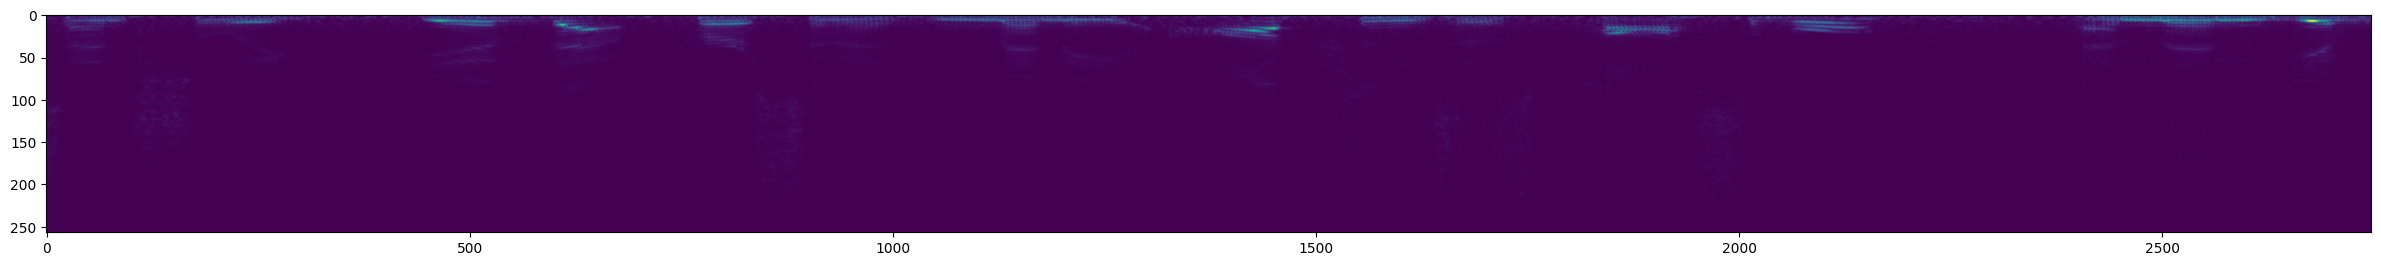

In [22]:
plt.figure(figsize = (30,20))
plt.imshow(tf.transpose(spec)[0])
plt.show()

In [23]:
data.as_numpy_iterator().next()

(b'/kaggle/input/data-sh/toxic/toxic_96_1.wav', 1.0)

In [24]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size = 10000)
data = data.batch(16)
data = data.prefetch(8)

Tensor("Cast:0", shape=(), dtype=int64)


In [25]:
len(data)*0.7

100.8

In [27]:
len(data)-100

44

In [28]:
train = data.take(100)
test = data.skip(100).take(45)

In [29]:
samples,labels = train.as_numpy_iterator().next()

In [30]:
samples.shape

(16, 2747, 257, 1)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten


In [32]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(2747, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [33]:
model.compile('Adam',loss = 'BinaryCrossentropy',metrics = [tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2745, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 2743, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 11103664)          0         
                                                                 
 dense (Dense)               (None, 128)               1421269120
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1421271729 (5.29 GB)
Trainable params: 1421271729 (5.29 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
hist = model.fit(train,epochs = 4,validation_data = test)

Epoch 1/4
